<a href="https://colab.research.google.com/github/jonatanbarkan/ACEDeep/blob/master/ADCEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [563]:
import numpy as np
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import tqdm
import pandas as pd
import matplotlib as mpl
from collections import defaultdict
from time import sleep

sns.set_style("whitegrid")
# mpl.rcParams['figure.figsize'] = [12., 8.0]


In [564]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [565]:
path_to_save = '/content/drive/My Drive/DeepACE/Linear_bad/'

In [566]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(0)

cpu


### Create Samples

In [567]:
d = 3
num_samples = 10000

In [568]:
mu = [0]*d
cov = np.eye(d)

In [569]:
kind = 'hex'
# kind = 'scatter'

In [570]:
def get_normalization_params(dat, axis=0):
  return dat.mean(axis=axis), dat.std(axis=axis)

In [571]:
def normalize(dat, mu, std):
  dat -= mu
  dat /= std
  return dat

In [572]:
Z = np.random.multivariate_normal(mu, cov, num_samples)
N1 = np.random.multivariate_normal(mu,  cov, num_samples)
N2 = np.random.multivariate_normal(mu,  cov, num_samples)
N3 = np.random.multivariate_normal(mu,  cov, num_samples)
N4 = np.random.multivariate_normal(mu,  cov, num_samples)

In [573]:
X_prior = Z + np.array([.5, .1, 1.2]) * N1
Y_prior = Z + np.array([.5, .1, 1.2]) * N2

In [574]:
# (np.array([.5, .1, 1.2]) * N1).shape

In [575]:
def draw_correlations(A, B, plot=True, labels=['A', 'B'], **kwargs):
  eziz = []
  for j in range(A.shape[-1]):
    cor = np.corrcoef(A[:,j], B[:,j], rowvar=False)[0,1]
    print(cor, end='\t')
    eziz.append(cor)
  temp = pd.DataFrame({
      **{f'${labels[0]}_{j}$': A[:, j] for j in range(A.shape[-1])},
      **{f'${labels[1]}_{j}$': B[:, j] for j in range(B.shape[-1])}
      })
  if plot:
    g = sns.PairGrid(data=temp,
                     y_vars=[f'${labels[0]}_{j}$' for j in range(A.shape[-1])],
                     x_vars=[f'${labels[1]}_{j}$' for j in range(B.shape[-1])]
                     )
    g.map(sns.scatterplot)
    g.fig.suptitle(kwargs.get('title', '').replace('_', ' ') + '\ncorrelations on diagonal: ' + f'   '.join(f'{c:.3}' for c in eziz), y=1.08)
    plt.tight_layout()
    if kwargs.get('save', True):
      plt.savefig(path_to_save + '{}.png'.format(kwargs.get('title', 'temp')))
  sleep(0.1)
  print('')
  return eziz

0.8006373851816506	0.9897881801142888	0.4146479364156491	


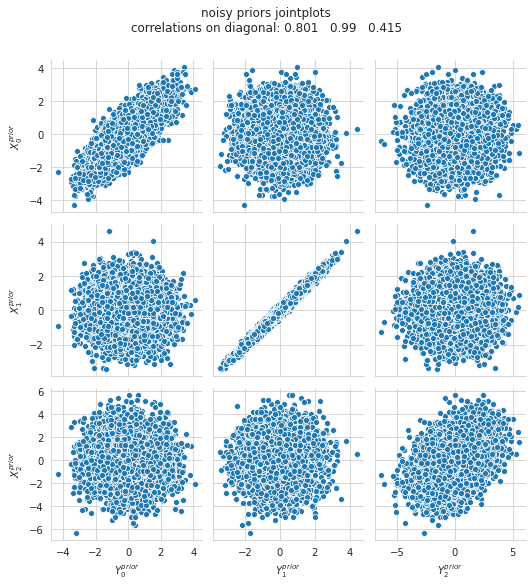

In [576]:
t = draw_correlations(X_prior, Y_prior, plot=True, labels=['X^{prior}', 'Y^{prior}'], title='noisy_priors_jointplots')

In [577]:
add_non_linearity = False

In [578]:
# torus prametrization
R = 5
def torus(vecs):
  a, b, c = vecs.T
  x1 = (R + c*np.cos(a))*np.cos(b)
  x2 = (R + c*np.cos(a))*np.sin(b)
  x3 = c*np.sin(a)
  return np.vstack((x1, x2, x3)).T


In [579]:
eps = 0.1
def rational(vecs):
  a, b, c = vecs.T
  x1 = a / (np.abs(b) + eps)
  x2 = c + 200
  x3 = a + 3*c
  return np.vstack((x1, x2, x3)).T


In [580]:
def swap(vecs):
  a, b, c = vecs.T
  return np.vstack((c, a, b)).T

In [581]:
non_linearity_1 = lambda a: a
non_linearity_2 = lambda a: a
if add_non_linearity:
  non_linearity_1 = lambda a: np.exp(a)
  non_linearity_2 = lambda a: np.arctan(np.pi * a)
  # non_linearity_1 = lambda a: np.log(1 + np.abs(a))
  # non_linearity_2 = lambda a: a + 1/a
  
  # non_linearity_1 = non_linearity_a

In [582]:
# non_linearity_1 = torus
# non_linearity_2 = rational

In [583]:
X_non_linear = non_linearity_1(X_prior)
Y_non_linear = non_linearity_2(swap(Y_prior))

0.0019398433720086412	-0.00505223486340971	0.004098505944834159	


[0.0019398433720086412, -0.00505223486340971, 0.004098505944834159]

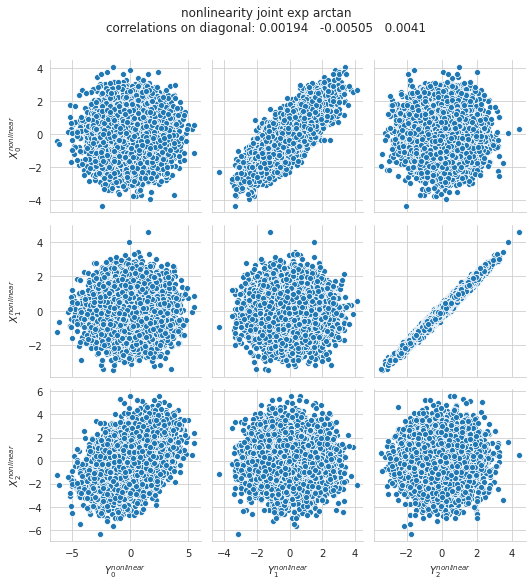

In [584]:
draw_correlations(X_non_linear, Y_non_linear, True, labels=['X^{nonlinear}', 'Y^{nonlinear}'], title='nonlinearity_joint_exp_arctan')

In [585]:
thetaX = [0] * d
thetaX[2] = np.pi/2
rot_axis_X = np.array([1, 1, 1])
rotX = Rotation.from_rotvec(thetaX * rot_axis_X)
X = rotX.apply(X_non_linear)

In [586]:
print(f'X: mean {np.mean(X, axis=0)}, std {np.std(X, axis=0)}')

X: mean [-0.0061841  -0.0029751   0.00389063], std [0.99709836 1.1346419  1.56403271]


In [587]:
X += np.array([.1, .1, .1]) * N3

In [588]:
thetaY = [0] * d
thetaY[0] = -np.pi / 2
thetaY[1] = -np.pi / 6
rot_axis_Y = np.array([1, 1, 1])
rotY = Rotation.from_rotvec(thetaY * rot_axis_Y)
Y = rotY.apply(Y_non_linear)

In [589]:
print(f'X: mean {np.mean(Y, axis=0)}, std {np.std(Y, axis=0)}')

X: mean [-0.02221667 -0.00393371 -0.01590042], std [1.4750083  1.07087425 1.16718347]


In [590]:
Y += np.array([.1, .1, .1]) * N4

$X, Y$ are rotations of a linear combination of $Z + \lambda N1$ and $Z + \lambda N2$ respectively, where $Z, N1, N2$ each drawn from a multivariate gaussian with 0 mean and unit covariance.
$\lambda=0.1$ and the rotations are different and are performed around different axes.

0.21148768440409857	0.018474864847473935	0.17972558105711595	


[0.21148768440409857, 0.018474864847473935, 0.17972558105711595]

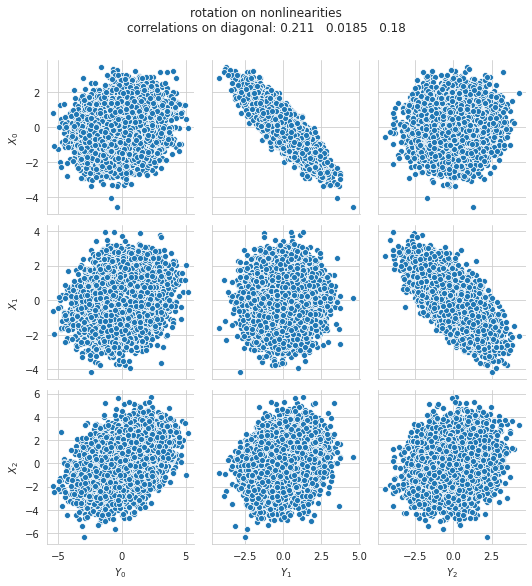

In [591]:
draw_correlations(X,Y, True, labels=['X', 'Y'], title='rotation_on_nonlinearities')

### create pytorch model class

notice there is no normalization at the final output. Normalization is performed with apply_transform function

In [592]:
class Model(nn.Module):
  def __init__(self, hidden_size, input_size, output_size, lr=0.01, activation=None):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_size)
      # nn.init.xavier_normal_(self.fc1.weight)
      self.bn1 = nn.BatchNorm1d(num_features=hidden_size)
      self.fc2 = nn.Linear(hidden_size, output_size)
      # nn.init.xavier_normal_(self.fc2.weight)
      self.bn2 = nn.BatchNorm1d(num_features=output_size, )
      self.activation = activation
      
  def forward(self, x):
      u = self.fc1(x)
      u = self.bn1(u)
      if self.activation is not None:
        u = self.activation(u)
      u = self.fc2(u)
      u = self.bn2(u)
      return u
  

In [593]:
class MlpNet(nn.Module):
    def __init__(self, layer_sizes, input_size, activation=None):
        super(MlpNet, self).__init__()
        if activation is None:
          activation = nn.Identity()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    nn.BatchNorm1d(num_features=layer_sizes[l_id], affine=False),
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    activation(),
                    nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=False),
                ))
        
        self.layers = nn.ModuleList(layers)
        # self.learning_rate = lr
        # self._criterion = nn.MSELoss()
        # self._optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [594]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y.detach(), yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [595]:
def make_eval_step(model, loss_fn):
    # Builds function that performs a step in the train loop
    def eval_step(x, y):
        # Sets model to TRAIN mode
        model.eval()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return eval_step

### train and eval functions

In [596]:
def find_orthogonal(M, vec):
  # M an orthogonal matrix, vec the starting vector to be orthogonalized wrt M
  # using (modified?) gram schmidt while assuming M is already orthogonal
  def projection(u, v):
      return ((v * u).sum() / (u * u).sum()) * u
  vec -= torch.sum(torch.cat([projection(M[i, :], vec) for i in range(M.shape[0])], dim=1))
  return vec 

In [597]:
def apply_initial_guess(inp, method='model', **kwargs):
  if method == 'model':
    return inp
  if method == 'independent':
    pass
  if method == 'mean':
    return (inp.mean() * torch.ones([inp.shape[0], 1])).detach()
  if method == 'zero':
    return torch.zeros([inp.shape[0], 1])
  
  raise NotImplementedError(f'initialization method {method} not implemented')

In [598]:
def apply_transform(model, inp, first=False, **kwargs):
  model.eval()
  out = model(inp)
  if first:
    out = apply_initial_guess(out, model=model, **kwargs)
  out -= out.mean(axis=0)
  std = out.std(axis=0)
  if not first:
    out = torch.div(out, out.std(axis=0))
  return out

In [599]:
def learn(loader, _x_model, _y_model, _x_train_step, _y_train_step, _max_samples=np.inf, first=False, **kwargs):
  U = []
  V = []
  losses_x = []
  losses_y = []

  sample_count = 0
  inner_loop_steps = kwargs.get('inner_loop_steps', 1)
  

  for i, (x_batch, y_batch) in enumerate(loader):
    sample_count += len(x_batch)
    # if sample_count > _max_samples:
    #   break
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    
    transformed_y_batch = apply_transform(_y_model, y_batch, first)
    for _ in range(inner_loop_steps):
      loss_x = _x_train_step(x_batch, transformed_y_batch)
    losses_x.append(loss_x)

    transformed_x_batch = apply_transform(_x_model, x_batch)
    for _ in range(inner_loop_steps):
      loss_y = _y_train_step(y_batch, transformed_x_batch)
    losses_y.append(loss_y)

    U.append(apply_transform(_y_model, y_batch))
    V.append(transformed_y_batch)

    if first:
      first = False
  U = torch.cat(U).cpu()
  V = torch.cat(V).cpu()
  # UV = U * V
  # corr = UV.mean(axis=0).item()
  # corr = draw_correlations(U.detach().numpy(), V.detach().numpy(), False)[0]
  corr = np.corrcoef(U.detach().numpy(), V.detach().numpy(), rowvar=False)[0, 1]

  return corr, np.mean(losses_x), np.mean(losses_y)


In [600]:
def evaluate(loader, _x_model, _y_model, _x_eval_step, _y_eval_step, first=False):
  X = []
  Y = []
  U = []
  V = []
  val_loss_x = []
  val_loss_y = []
  with torch.no_grad(): 
    for x_val, y_val in loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      transformed_y_batch = apply_transform(_y_model, y_val, first)
      transformed_x_batch = apply_transform(_x_model, x_val, first)

      X.append(x_val)
      Y.append(y_val)
      U.append(transformed_x_batch)
      V.append(transformed_y_batch)

      val_loss_x.append(_x_eval_step(x_val, transformed_y_batch))
      val_loss_y.append(_y_eval_step(y_val, transformed_x_batch))
  X = torch.cat(X).cpu()
  Y = torch.cat(Y).cpu()
  U = torch.cat(U).cpu()
  V = torch.cat(V).cpu()
  corr = np.corrcoef(U, V, rowvar=False)[0, 1]
  return corr, (X, Y, U, V), np.mean(val_loss_x), np.mean(val_loss_y)


In [601]:
def build_models(cls, *args, **kwargs):
  model1 = cls(*args)
  model2 = cls(*args)

  model1 = model1.to(device)
  model2 = model2.to(device)

  model1_criterion = nn.MSELoss()
  model1_opt = torch.optim.Adam(model1.parameters(), lr=kwargs.get('learning_rate', 0.01))

  model2_criterion = nn.MSELoss()
  model2_opt = torch.optim.Adam(model2.parameters(), lr=kwargs.get('learning_rate', 0.01))

  train_step1 = make_train_step(model1, model1_criterion, model1_opt)
  train_step2 = make_train_step(model2, model2_criterion, model2_opt)

  eval_step1 = make_eval_step(model1, model1_criterion)
  eval_step2 = make_eval_step(model2, model2_criterion)
  return model1, model2, train_step1, train_step2, eval_step1, eval_step2


### create data split

In [602]:
x_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(Y).float()
z_tensor = torch.from_numpy(Z).float()

In [603]:
from sklearn.model_selection import train_test_split

In [604]:
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(x_tensor, y_tensor, z_tensor, test_size=0.3, random_state=42, shuffle=True)

In [605]:
muX, stdX = get_normalization_params(X_train)
muY, stdY = get_normalization_params(Y_train)
muZ, stdZ = get_normalization_params(Z_train)

In [606]:
# X_train = normalize(X_train, muX, stdX)
# X_test = normalize(X_test, muX, stdX)
# Y_train = normalize(Y_train, muY, stdY)
# Y_test = normalize(Y_test, muY, stdY)
# Z_train = normalize(Z_train, muZ, stdZ)
# Z_test = normalize(Z_test, muZ, stdZ)

In [607]:
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_test, Y_test)

In [608]:
# train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

### Run

In [609]:
max_samples = len(train_dataset) // 1

In [610]:
max_samples

7000

In [611]:
wanted_dim = 1

In [931]:
hidden_size = 1
max_epochs = 25
lr = 0.001
act = None
# act = F.softsign
# act = torch.sin
# act = F.relu
act = nn.ReLU
act = nn.ELU
# act = nn.Sigmoid
# batch_size = len(train_dataset) // 100
batch_size = 32

In [932]:
print(batch_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=min(len(val_dataset), 500))

32


In [933]:
layer_sizes = [hidden_size, hidden_size, hidden_size, wanted_dim]
x_model, y_model, x_train_step, y_train_step, x_eval_step, y_eval_step = \
  build_models(MlpNet, layer_sizes, X.shape[-1], act, learning_rate=lr)

0.050109287945327596	


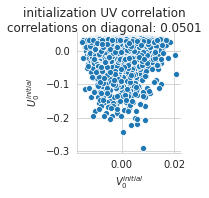

In [934]:
first = True

last_score, (_, _, Us, Vs) , val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model, x_eval_step, y_eval_step, first=first)
draw_correlations(Us, Vs, True, labels=['U^{initial}', 'V^{initial}'], title='initialization_UV_correlation')
training_first_score, (_, _, Us, Vs) , train_x_loss, train_y_loss = evaluate(train_loader, x_model, y_model, x_eval_step, y_eval_step, first=first)

In [935]:
s = f'epoch: {-1}\tscore(correlation) {last_score:.3}\tX model loss {val_x_loss:.3}\tY model loss {val_y_loss:.3}'
print(s)

epoch: -1	score(correlation) 0.0501	X model loss 0.00371	Y model loss 0.571


In [936]:
scores = defaultdict(list)
losses = defaultdict(list)
mean_statistics = defaultdict(list)
std_statistics = defaultdict(list)

In [937]:
log_scores_before_learning = False

if log_scores_before_learning:
  scores['Ours'].append(last_score)
  # scores['training'].append(training_first_score)
  scores['epoch'].append(-1)

  mean_statistics['U_mean'] = Us.mean().item()
  mean_statistics['V_mean'] = Vs.mean().item()
  std_statistics['U_std'] = Us.std().item()
  std_statistics['V_std'] = Vs.std().item()
  mean_statistics['epoch'].append(-1)
  std_statistics['epoch'].append(-1)

  losses['x_model_validation'].append(val_x_loss)
  losses['y_model_validation'].append(val_y_loss)
  losses['x_model_training'].append(train_x_loss)
  losses['y_model_training'].append(train_y_loss)
  losses['epoch'].append(-1)

In [ ]:
max_score = -np.inf

for epoch in range(max_epochs):
  # train
  train_score, train_x_loss, train_y_loss = learn(train_loader, x_model, y_model, x_train_step, y_train_step, _max_samples=max_samples, first=first)
  if first:
    first = False
  # validate
  current_score, (Xs, Ys, Us, Vs), val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model, x_eval_step, y_eval_step)

  # log
  # scores['training'].append(train_score)
  losses['x_model_training'].append(train_x_loss)
  losses['y_model_training'].append(train_y_loss)
  losses['x_model_validation'].append(val_x_loss)
  losses['y_model_validation'].append(val_y_loss)
  
  mean_statistics['U_mean'] = Us.mean().item()
  mean_statistics['V_mean'] = Vs.mean().item()
  std_statistics['U_std'] = Us.std().item()
  std_statistics['V_std'] = Vs.std().item()

  scores['Ours'].append(current_score)
  
  scores['epoch'].append(epoch)
  losses['epoch'].append(epoch)
  mean_statistics['epoch'].append(epoch)
  std_statistics['epoch'].append(epoch)

  print(f'epoch: {epoch}\tscore(correlation) {last_score:.3}\tX model loss {val_x_loss:.3}\tY model loss {val_y_loss:.3}')
  
  if current_score > max_score:
    max_score = current_score
    torch.save(x_model, 'x_model_best.pth')
    torch.save(y_model, 'y_model_best.pth')
  last_score = current_score

epoch: 0	score(correlation) 0.0501	X model loss 0.839	Y model loss 1.35
epoch: 1	score(correlation) 0.409	X model loss 0.879	Y model loss 0.856
epoch: 2	score(correlation) 0.692	X model loss 0.406	Y model loss 0.533
epoch: 3	score(correlation) 0.796	X model loss 0.316	Y model loss 0.369
epoch: 4	score(correlation) 0.843	X model loss 0.167	Y model loss 0.173
epoch: 5	score(correlation) 0.942	X model loss 0.0848	Y model loss 0.0726
epoch: 6	score(correlation) 0.978	X model loss 0.0781	Y model loss 0.0573
epoch: 7	score(correlation) 0.98	X model loss 0.0908	Y model loss 0.0546
epoch: 8	score(correlation) 0.98	X model loss 0.138	Y model loss 0.0541
epoch: 9	score(correlation) 0.98	X model loss 0.353	Y model loss 0.0538
epoch: 10	score(correlation) 0.98	X model loss 0.123	Y model loss 0.0536
epoch: 11	score(correlation) 0.98	X model loss 0.711	Y model loss 0.0543
epoch: 12	score(correlation) 0.98	X model loss 0.263	Y model loss 0.0542
epoch: 13	score(correlation) 0.98	X model loss 2.13	Y mo

In [ ]:
x_model.eval()
y_model.eval()
print()

In [ ]:
x_model_best = torch.load('x_model_best.pth')
x_model_best.eval()

y_model_best = torch.load('y_model_best.pth')
y_model_best.eval()

print()

In [ ]:
# re-evaluate
Us = x_model_best(X_test).detach().numpy()
Vs = y_model_best(Y_test).detach().numpy()

In [ ]:
draw_correlations(Us, Vs, True, labels=['U^{best}', 'V^{best}'], title='best_UV_correlation')
print(f'U_final: mean {Us.mean(axis=0).item()}, std {Us.std(axis=0).item()}')
print(f'V_final: mean {Vs.mean(axis=0).item()}, std {Vs.std(axis=0).item()}')

Find linear CCA result for wanted dim

In [ ]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1)
X_train_c, Y_train_c = cca.fit_transform(X_train, Y_train)
X_c, Y_c = cca.transform(X_test, Y_test)
print(f'X_c: mean {X_c.mean(axis=0)}, std {X_c.std(axis=0)}')
print(f'Y_c: mean {Y_c.mean(axis=0)}, std {Y_c.std(axis=0)}')

In [ ]:
cor = np.corrcoef(X_c.T, Y_c.T)
mask = np.ones(cor.shape, dtype=bool)
np.fill_diagonal(mask, 0)
np.abs(cor[mask]).max()

In [ ]:
# CCAtrain = draw_correlations(X_train_c, Y_train_c)
CCAtest = draw_correlations(X_c, Y_c, True, labels=[r'U^{LCCA}', r'V^{LCCA}'], title='linearCCA_UV_correlation')

In [ ]:
draw_correlations(Us, X_c, True, labels=['U', 'U^{LCCA}'], title=r'U_vs_U_LCCA_correlations')
draw_correlations(Vs, Y_c, True, labels=['V', 'V^{LCCA}'], title=r'V_vs_V_LCCA_correlations')

In [ ]:
cor = np.corrcoef(Us, Z_test, False)
mask = np.ones(cor.shape, dtype=bool)
np.fill_diagonal(mask, 0)
max_UZ_cor = np.abs(cor[mask]).max()

In [ ]:
cor = np.corrcoef(Vs, Z_test, False)
mask = np.ones(cor.shape, dtype=bool)
np.fill_diagonal(mask, 0)
max_VZ_cor = np.abs(cor[mask]).max()

In [ ]:
temp = pd.DataFrame({
      **{f'$U_{j}$': Us[:, j] for j in range(Us.shape[-1])},
      **{f'$V_{j}$': Vs[:, j] for j in range(Vs.shape[-1])},
      **{f'$Z_{j}$': Z_test[:, j] for j in range(Z_test.shape[-1])},
      })
g = sns.PairGrid(
    data=temp,
    y_vars=[f'$U_{j}$' for j in range(Us.shape[-1])] + [f'$V_{j}$' for j in range(Vs.shape[-1])],
    x_vars=[f'$Z_{j}$' for j in range(Z_test.shape[-1])]
    )
g.map(sns.scatterplot)
g.fig.suptitle('UVZ_correlations' + '\nmax correlations UZ, VZ: ' + f'   '.join(f'{c:.3}' for c in [max_UZ_cor, max_VZ_cor]), y=1.08)
plt.tight_layout()
plt.savefig(path_to_save + 'UVZ_correlations.png')

In [ ]:
# scores['LinearCCA training'] = [max(CCAtrain)] * len(scores['epoch'])
scores['LinearCCA'] = [max(CCAtest)] * len(scores['epoch'])
scores['Maximum score'] = [max(draw_correlations(X_prior, Y_prior, False, ))] * len(scores['epoch'])
# scores['Maximum Linear score'] = [max(draw_correlations(X_non_linear, Y_non_linear))] * len(scores['epoch'])

In [ ]:
mean_statistics_data = pd.DataFrame(mean_statistics)
df_mean_statistics = pd.melt(mean_statistics_data, 'epoch')
std_statistics_data = pd.DataFrame(std_statistics)
df_std_statistics = pd.melt(std_statistics_data, 'epoch')

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2)
sns.lineplot('epoch', 'value', 'variable', data=df_mean_statistics, ax=ax0)
sns.lineplot('epoch', 'value', 'variable', data=df_std_statistics, ax=ax1)
ax0.ticklabel_format(useOffset=False)
ax1.ticklabel_format(useOffset=False)
f.suptitle('statistics of test outputs during run', y=1.08)
plt.tight_layout()
plt.savefig(path_to_save + 'test_statistics.png')

In [ ]:
scores_data = pd.DataFrame(scores)
df_scores = pd.melt(scores_data[scores_data.epoch != -1], 'epoch', var_name='Model', value_name='correlation')
g = sns.lineplot('epoch', 'correlation', 'Model', data=df_scores)
g.set_title('score of test outputs during run', y=1.08)
plt.tight_layout()
plt.savefig(path_to_save + 'test_scores.png')

In [ ]:
losses_data = pd.DataFrame(losses)
df_losses = pd.melt(losses_data, 'epoch', var_name='model', value_name='error')
g = sns.lineplot('epoch', 'error', 'model', data=df_losses)
g.set_title('errors during run', y=1.08)
plt.tight_layout()
plt.savefig(path_to_save + 'errors.png')